In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [91]:
ds = pd.read_csv('healthcare-dataset-stroke-data.csv', delimiter=',')

In [92]:
ds.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [93]:
ds.drop(['id'], axis=1, inplace=True)

In [94]:
ds.stroke[ds.gender == 'Other']

3116    0
Name: stroke, dtype: int64

In [95]:
ds.drop([3116], inplace=True)

In [96]:
ds.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [97]:
columns_numeric = ['age', 'avg_glucose_level', 'bmi']
columns_categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                       'work_type', 'Residence_type', 'smoking_status']
columns_dummis = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
columns_target = ['stroke']

In [98]:
def replace_nan(data, to_replace, replacement_data):
    
    data_def = data.copy(deep=True)
    
    index_zero = list(data_def[to_replace][data_def[replacement_data] == 0].index)
    index_one = list(data_def[to_replace][data_def[replacement_data] == 1].index)
    
    for i in range(2):
        minimum = data_def[to_replace][data_def[replacement_data] == i].quantile(0.25)
        maximum = data_def[to_replace][data_def[replacement_data] == i].quantile(0.75)
        
        minimum -= (maximum - minimum) * 0.5
        maximum += (maximum - minimum) * 0.5
    
        count = data_def[to_replace][data_def[replacement_data] == i].isnull().sum()
        
        data_for_nan = np.random.choice(range(int(minimum), int(maximum)), count)
    
        if i == 0:
            index_null = data_def[to_replace][index_zero][data_def[to_replace].isnull()].index
        else:
            index_null = data_def[to_replace][index_one][data_def[to_replace].isnull()].index
        
        data_def[to_replace][index_null] = data_for_nan
        
    return data_def

In [99]:
ds = replace_nan(ds, 'bmi', 'stroke')

In [100]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 639.0+ KB


In [101]:
ds = pd.get_dummies(ds, columns=columns_dummis, prefix_sep='_', drop_first=True)

In [102]:
ds.head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,26.0,1,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0


In [103]:
from sklearn.model_selection import train_test_split

In [104]:
ds_train, ds_test = train_test_split(ds, test_size=0.3, random_state=42, stratify=ds.stroke)

In [105]:
ds_train.stroke.value_counts(normalize=True), ds_test.stroke.value_counts(normalize=True)

(0    0.951342
 1    0.048658
 Name: stroke, dtype: float64,
 0    0.951076
 1    0.048924
 Name: stroke, dtype: float64)

In [106]:
ds_train.shape[0] + ds_test.shape[0], ds.shape

(5109, (5109, 16))

In [107]:
add_rows = int(ds_train.stroke.value_counts()[0] * .8 - ds_train.stroke.value_counts()[1])
add_rows

2547

In [108]:
int(add_rows / ds_train.stroke.value_counts()[1]), ds_train.stroke.value_counts()

(14,
 0    3402
 1     174
 Name: stroke, dtype: int64)

In [109]:
index_train_one = ds_train.stroke[ds_train.stroke == 1].index
ds_train_one = ds_train.loc[index_train_one]

In [110]:
for i in range(14):
    ds_train = ds_train.append(ds_train_one)
    #y_train = pd.concat([y_train, y_train[y_train == 1]])

In [111]:
ds_train.stroke.value_counts(normalize=True)

0    0.565868
1    0.434132
Name: stroke, dtype: float64

In [112]:
from sklearn.utils import shuffle

In [113]:
ds_train = shuffle(ds_train)

### --------------- metrics ------------------------

In [114]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

In [115]:
def print_metrics(actual, predict):
    print('Accuracy: {:.3f}'.format(accuracy_score(actual, predict)))
    print('Precision: {:.3f}'.format(precision_score(actual, predict)))
    print('Recall: {:.3f}'.format(recall_score(actual, predict)))
    print('F1 score: {:.3f}'.format(f1_score(actual, predict)))

In [116]:
def plot_roc_auc(actual, predict):
    
    fpr, tpr, threshold = roc_curve(actual, predict)
    plt.plot(fpr, tpr, color='b')
    #plt.plot()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0.0, 1.0], [0.0, 1.0], color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC = {:.3f}'.format(roc_auc_score(actual, predict)))

### -------------- Tree ----------------------

In [117]:
from sklearn.tree import DecisionTreeClassifier

In [118]:
model_tree = DecisionTreeClassifier(random_state=33)

In [119]:
model_tree.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)

DecisionTreeClassifier(random_state=33)

In [120]:
y_pred = model_tree.predict(ds_test.drop(['stroke'], axis=1))

In [121]:
y_pred_proba = model_tree.predict_proba(ds_test.drop(['stroke'], axis=1))

In [122]:
print_metrics(ds_test.stroke, y_pred)

Accuracy: 0.922
Precision: 0.133
Recall: 0.107
F1 score: 0.119


In [123]:
conf_matrix = confusion_matrix(ds_test.stroke, y_pred)

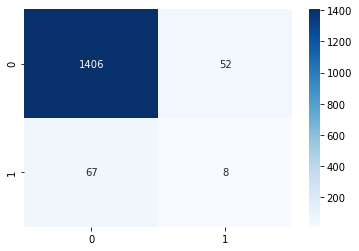

In [124]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='');

### ---------- selection of parameters ----------------

In [125]:
%%time
best_f1 = []
best_recall = []
best_roc_auc = []
best_precision = [] 
x = []
x_keys = []
n = 0

for cr in ['gini', 'entropy']:
    for sp in ['best', 'random']:
        for depth in [1, 2, 3, 4, 5, 6, 7, None]:
            for leaf in [1, 2, 3, 4, 5]:
                for feature in [1, 2, 3, 4, 'sqrt', 'log2']:
                    model = DecisionTreeClassifier(criterion=cr, splitter=sp, max_depth=depth, 
                                                   min_samples_leaf=leaf, max_features=feature, 
                                                   random_state=33)
                                
                    model.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)
                    y_pred = model.predict(ds_test.drop(['stroke'], axis=1))
                                
                    f1 = f1_score(ds_test.stroke, y_pred)
                    best_f1.append(f1)
                                
                    recall = recall_score(ds_test.stroke, y_pred)
                    best_recall.append(recall)
                                
                    precision = precision_score(ds_test.stroke, y_pred)
                    best_precision.append(precision)
                                
                    y_pred_prob = model.predict_proba(ds_test.drop(['stroke'], axis=1))
                    roc_auc = roc_auc_score(ds_test.stroke, y_pred_prob[:, 1])
                    best_roc_auc.append(roc_auc)
                                
                    x_keys.append(str(cr) +' '+ str(sp) +' '+ str(depth) +' '+ str(leaf) +' '+ 
                                  str(feature))
                    x.append(n)
                    n += 1

CPU times: user 12.2 s, sys: 28 ms, total: 12.2 s
Wall time: 12.2 s


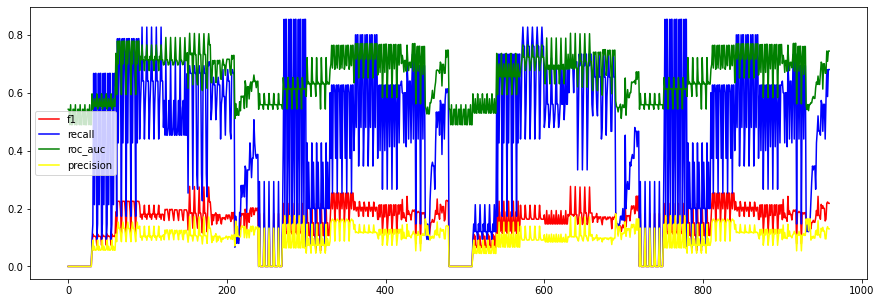

In [126]:
plt.figure(figsize=(15, 5))
plt.plot(x, best_f1, c='r', label='f1')
plt.plot(x, best_recall, c='b', label='recall')
plt.plot(x, best_roc_auc, c='green', label='roc_auc')
plt.plot(x, best_precision, c='yellow', label='precision')
plt.legend()
plt.show()

In [127]:
data_score = {'f1': best_f1, 'recall': best_recall, 'precision': best_precision, 'roc_auc': best_roc_auc}

In [128]:
ds_scores = pd.DataFrame(data_score, index=x_keys)

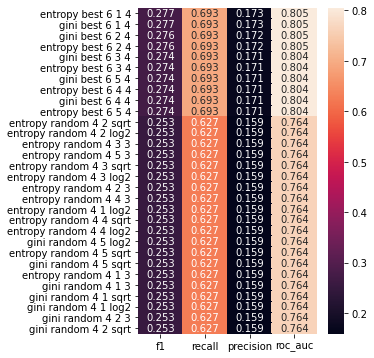

In [129]:
plt.figure(figsize=(4, 6))
sns.heatmap(ds_scores.sort_values(by=['f1'], ascending=False)[:30], annot=True, fmt='.3f');

#### ------------------- selection of random_state -------------------

In [130]:
%%time
best_f1 = []
best_recall = []
best_roc_auc = []
best_precision = [] 
x = []
x_keys = []
n = 0

for i in range(200):
    model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=6, min_samples_leaf=1, 
                                   max_features=4, random_state=i)
    
    model.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)
    y_pred = model.predict(ds_test.drop(['stroke'], axis=1))
    
    f1 = f1_score(ds_test.stroke, y_pred)
    best_f1.append(f1)
    
    recall = recall_score(ds_test.stroke, y_pred)
    best_recall.append(recall)
                                
    precision = precision_score(ds_test.stroke, y_pred)
    best_precision.append(precision)
                                
    y_pred_prob = model.predict_proba(ds_test.drop(['stroke'], axis=1))
    roc_auc = roc_auc_score(ds_test.stroke, y_pred_prob[:, 1])
    best_roc_auc.append(roc_auc)
    
    x.append(n)
    n += 1   

CPU times: user 3.28 s, sys: 0 ns, total: 3.28 s
Wall time: 3.28 s


In [131]:
best_rs = pd.DataFrame({'f1': best_f1, 'recall': best_recall, 'precision': best_precision, 
                        'roc_auc': best_roc_auc}, index=x)

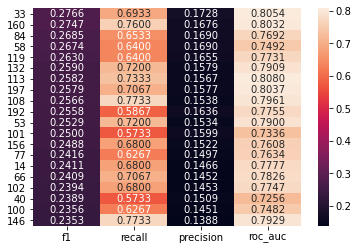

In [132]:
sns.heatmap(best_rs.sort_values(by=['f1'], ascending=False)[:20], annot=True, fmt='.4f');

In [151]:
model_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=6, min_samples_leaf=1, 
                                    max_features=4, random_state=160)

In [152]:
model_tree.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)

DecisionTreeClassifier(max_depth=6, max_features=4, random_state=160)

In [153]:
y_pred_prob = model_tree.predict_proba(ds_test.drop(['stroke'], axis=1))

In [154]:
print_metrics(ds_test.stroke, y_pred)

Accuracy: 0.702
Precision: 0.095
Recall: 0.600
F1 score: 0.165


In [155]:
conf_matrix = confusion_matrix(ds_test.stroke, y_pred)

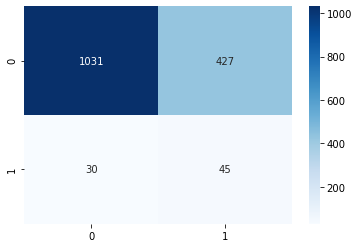

In [156]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='');

### ------------- selection of threshold -----------------

In [157]:
model_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=6, min_samples_leaf=1, 
                                   max_features=4, random_state=160)

In [158]:
model_tree.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)

DecisionTreeClassifier(max_depth=6, max_features=4, random_state=160)

In [159]:
y_pred_prob = model_tree.predict_proba(ds_test.drop(['stroke'], axis=1))

In [160]:
f1_sc = []
threshold = []
rec_sc = []
prec_sc = []
x = []

for i in np.linspace(0.0, 1.0, 100):
    recall_sc = recall_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    precision_sc = precision_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    f_one = f1_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    f1_sc.append(f_one)
    threshold.append(i)
    rec_sc.append(recall_sc)
    prec_sc.append(precision_sc)
    x.append(i)

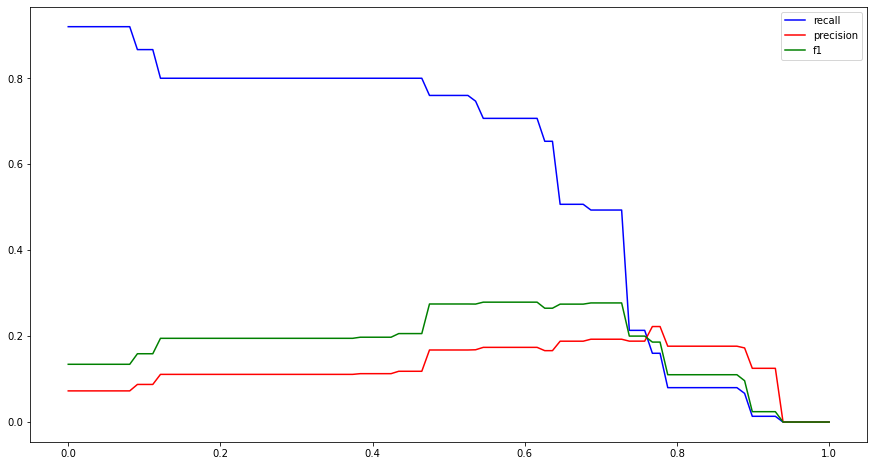

In [161]:
plt.figure(figsize=(15, 8))
plt.plot(np.linspace(0.0, 1.0, 100), rec_sc, color='b', label='recall')
plt.plot(np.linspace(0.0, 1.0, 100), prec_sc, color='r', label='precision')
plt.plot(np.linspace(0.0, 1.0, 100), f1_sc, color='green', label='f1')
plt.legend(loc='upper right')
plt.show()

In [162]:
ds_sc = pd.DataFrame({'threshold': threshold,'f1': f1_sc, 'recall': rec_sc, 'precision': prec_sc}, index=x)

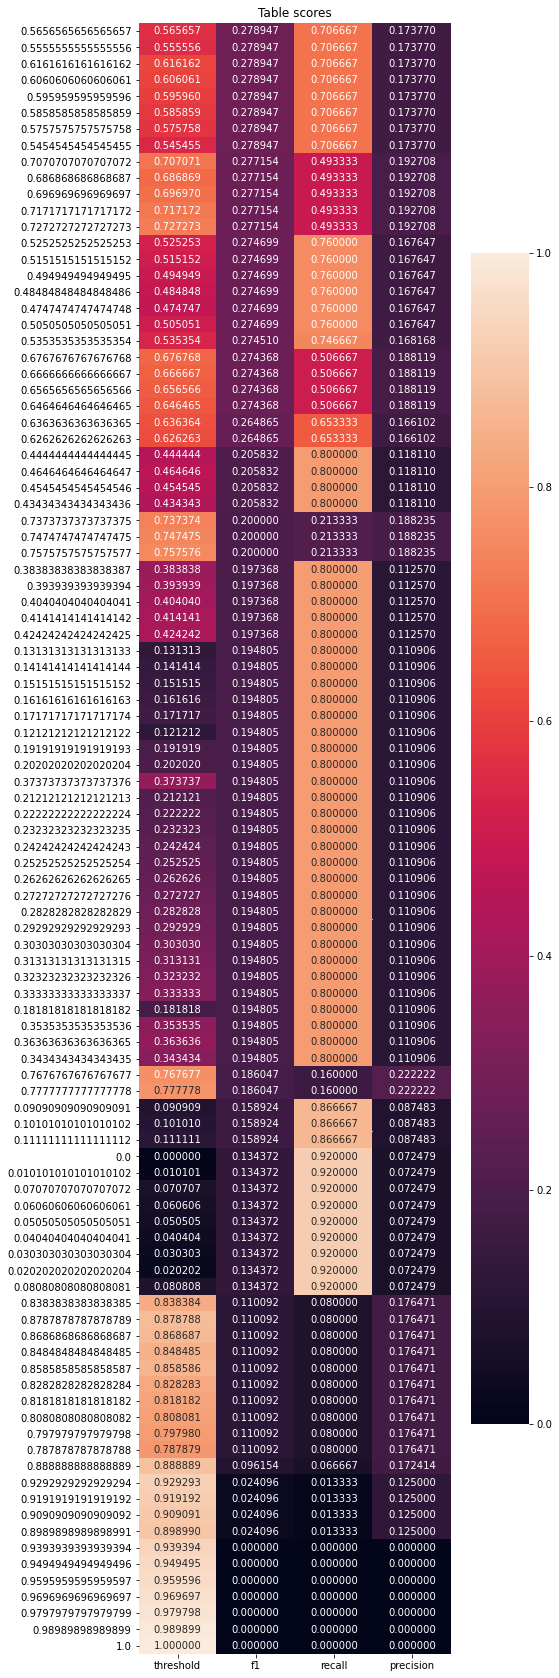

In [163]:
plt.figure(figsize=(7, 30))
sns.heatmap(ds_sc.sort_values(by='f1',ascending=False), annot=True, fmt='.6f')
plt.title('Table scores');

In [164]:
conf_matrix = confusion_matrix(ds_test.stroke, y_pred_prob[:, 1] > 0.4949494949494)

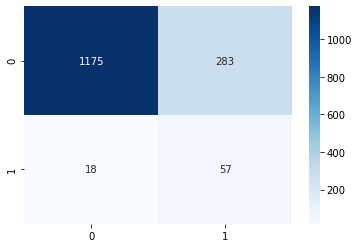

In [165]:
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='');

In [166]:
print_metrics(ds_test.stroke, y_pred_prob[:, 1] > 0.4949494949494)

Accuracy: 0.804
Precision: 0.168
Recall: 0.760
F1 score: 0.275


#### ------------------------- Graph --------------------------------

In [167]:
import pydot
import sklearn
from graphviz import Source

In [172]:
r = sklearn.tree.export_text(model_tree, feature_names=list(ds_test.drop(['stroke'], axis=1).columns))
file = open('graph_tree.txt', 'w')
file.write(r)
file.close()

In [178]:
graph = Source(sklearn.tree.export_graphviz(model_tree, out_file=None, 
                                            feature_names=ds_test.drop(['stroke'], axis=1).columns))

In [179]:
png_bytes = graph.pipe(format='png')

with open('graph_tree.png', 'wb') as t:
    t.write(png_bytes) 

### --------------- Bagging ------------------

In [180]:
from sklearn.ensemble import BaggingClassifier

In [183]:
model_bagging = BaggingClassifier(model_tree, n_estimators=1000, max_samples=100, bootstrap=True,
                                 random_state=160, n_jobs=-1)

In [184]:
%%time
model_bagging.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)

CPU times: user 100 ms, sys: 12 ms, total: 112 ms
Wall time: 868 ms


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        max_features=4,
                                                        random_state=160),
                  max_samples=100, n_estimators=1000, n_jobs=-1,
                  random_state=160)

In [187]:
y_pred = model_bagging.predict(ds_test.drop(['stroke'], axis=1))

In [188]:
y_pred_prob = model_bagging.predict_proba(ds_test.drop(['stroke'], axis=1))

In [189]:
print_metrics(ds_test.stroke, y_pred)

Accuracy: 0.750
Precision: 0.138
Recall: 0.787
F1 score: 0.236


In [190]:
f1_sc = []
threshold = []
rec_sc = []
prec_sc = []
x = []

for i in np.linspace(0.0, 1.0, 100):
    recall_sc = recall_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    precision_sc = precision_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    f_one = f1_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    f1_sc.append(f_one)
    threshold.append(i)
    rec_sc.append(recall_sc)
    prec_sc.append(precision_sc)
    x.append(i)

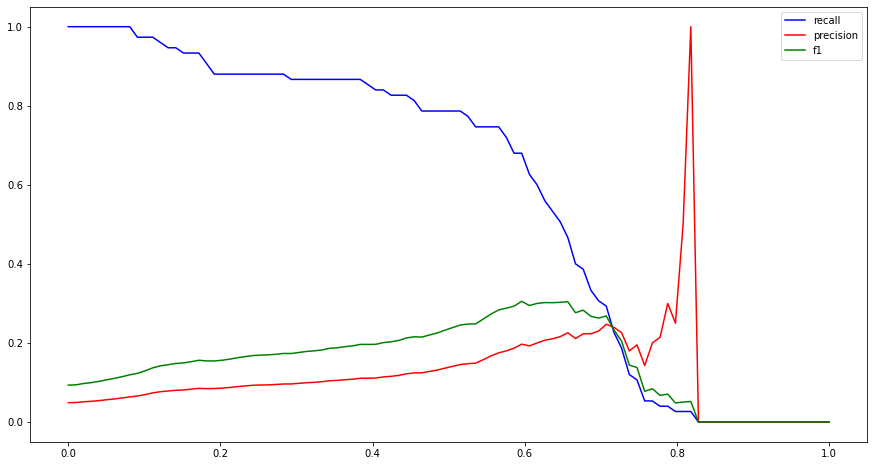

In [191]:
plt.figure(figsize=(15, 8))
plt.plot(np.linspace(0.0, 1.0, 100), rec_sc, color='b', label='recall')
plt.plot(np.linspace(0.0, 1.0, 100), prec_sc, color='r', label='precision')
plt.plot(np.linspace(0.0, 1.0, 100), f1_sc, color='green', label='f1')
plt.legend(loc='upper right')
plt.show()

In [192]:
ds_sc = pd.DataFrame({'threshold': threshold,'f1': f1_sc, 'recall': rec_sc, 'precision': prec_sc}, index=x)

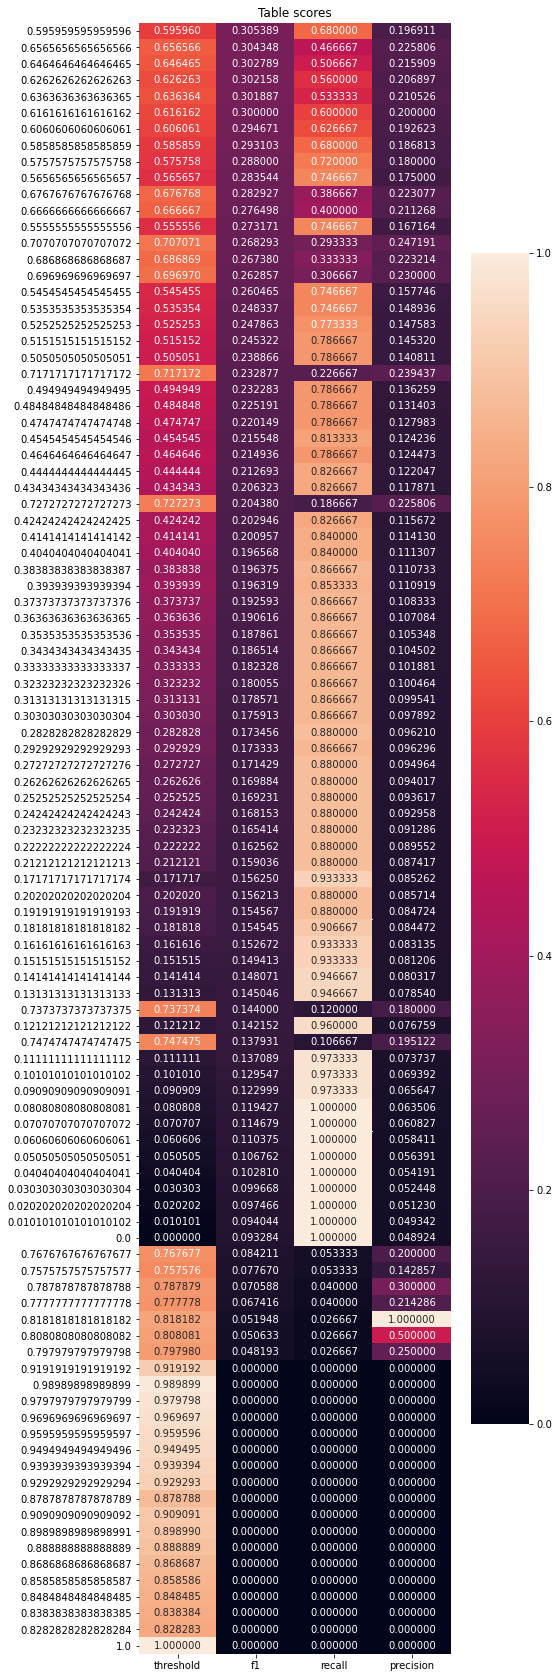

In [193]:
plt.figure(figsize=(7, 30))
sns.heatmap(ds_sc.sort_values(by='f1',ascending=False), annot=True, fmt='.6f')
plt.title('Table scores');

In [194]:
conf_matrix = confusion_matrix(ds_test.stroke, y_pred_prob[:, 1] > 0.59595959595959)

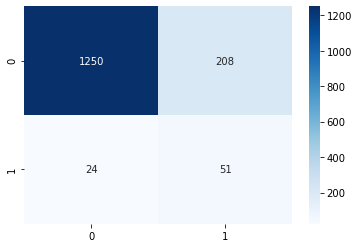

In [195]:
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='');

In [196]:
print_metrics(ds_test.stroke, y_pred_prob[:, 1] > 0.5959595959595959)

Accuracy: 0.849
Precision: 0.197
Recall: 0.680
F1 score: 0.305
